In [1]:
!python -m spacy download en_core_web_sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import spacy
from spacy.lang.en import English
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /Users/venessa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!wget https://raw.githubusercontent.com/vennietweek/aita-analysis-tool/main/submissions_part1.csv
!wget https://raw.githubusercontent.com/vennietweek/aita-analysis-tool/main/submissions_part2.csv

zsh:1: command not found: wget
zsh:1: command not found: wget


In [3]:
part1 = pd.read_csv('submissions_part1.csv', parse_dates=[0])
part2 = pd.read_csv('submissions_part2.csv', parse_dates=[0])
df = pd.concat([part1, part2])
df

,created_time,title,score,id,content,AITA,upvotes
0,2021-07-03 12:36:22,AITA for telling my wife the lock on my daught...,81014,ocx94s,My brother in-law (Sammy) lost his home shortl...,Not the A-hole,81014
1,2020-05-26 23:35:45,AITA For suing my girlfriend after she had my ...,70809,gr8bp3,I'll try to keep this short. I had a [1967 Imp...,Not the A-hole,70809
2,2019-12-03 17:07:53,AITA for pretending to get fired when customer...,63520,e5k3z2,I am a high schooler with a weekend job at a c...,Not the A-hole,63520
3,2022-12-26 12:44:43,"AITA for bringing up my brother's ""premature"" ...",60429,zvmflw,I am a nurse practitioner and I am the primary...,Not the A-hole,60429
4,2022-08-26 20:25:55,AITA for not taking down my video that was a g...,55748,wyjbjs,I have a sister that’s 6 years older than me. ...,Not the A-hole,55748
...,...,...,...,...,...,...,...
5956,2021-09-14 14:50:35,AITA for not letting my brother's girlfriend m...,5256,po4alt,I'm the middle child of 3 siblings. There's my...,Not the A-hole,5256
5957,2023-02-27 06:40:02,AITA for telling my husband I want his sisters...,2271,11d4zrj,"Please let me know if I’m in the wrong, becaus...",Not the A-hole,2271
5958,2023-09-19 22:29:59,AITA for telling my wife her sister can’t help...,2060,16n4e8z,My wife Dee (28F) and I (27M) recently had our...,Asshole,2060
5959,2023-12-07 17:55:08,AITA for telling my daughter (who is facing ho...,10580,18d19q5,**UPDATE:** *I do believe because of my anger ...,Not the A-hole,10580


In [4]:
df['AITA'].value_counts()

AITA
Not the A-hole     9708
Asshole            1782
No A-holes here     433
Name: count, dtype: int64

In [5]:
df['asshole_flag'] = df['AITA'].apply(lambda x : 1 if x == "Asshole" else 0)

In [6]:
df['asshole_flag'].value_counts()

asshole_flag
0    10141
1     1782
Name: count, dtype: int64

In [7]:
def count_sentences(text):
  return len(nltk.sent_tokenize(text))

df['num_of_sentences'] = df['content'].apply(count_sentences)
df.head()

,created_time,title,score,id,content,AITA,upvotes,asshole_flag,num_of_sentences
0,2021-07-03 12:36:22,AITA for telling my wife the lock on my daught...,81014,ocx94s,My brother in-law (Sammy) lost his home shortl...,Not the A-hole,81014,0,23
1,2020-05-26 23:35:45,AITA For suing my girlfriend after she had my ...,70809,gr8bp3,I'll try to keep this short. I had a [1967 Imp...,Not the A-hole,70809,0,42
2,2019-12-03 17:07:53,AITA for pretending to get fired when customer...,63520,e5k3z2,I am a high schooler with a weekend job at a c...,Not the A-hole,63520,0,20
3,2022-12-26 12:44:43,"AITA for bringing up my brother's ""premature"" ...",60429,zvmflw,I am a nurse practitioner and I am the primary...,Not the A-hole,60429,0,38
4,2022-08-26 20:25:55,AITA for not taking down my video that was a g...,55748,wyjbjs,I have a sister that’s 6 years older than me. ...,Not the A-hole,55748,0,45


In [8]:
# Preprocessing for RNN
tokenizer = Tokenizer(num_words=10000) # Only consider the top 10k words
tokenizer.fit_on_texts(df['content']) # Fit tokenizer on the content
sequences = tokenizer.texts_to_sequences(df['content']) # Convert text to sequences
data = pad_sequences(sequences, maxlen=100) # Pad sequences to the same length
word_index = tokenizer.word_index # Print word index to see unique tokens
print('Found %s unique tokens.' % len(word_index)) 
labels = np.asarray(df['asshole_flag']).astype('float32') # Convert labels to Numpy array


Found 48107 unique tokens.


In [9]:
# Create a SMOTE object which is used for data resampling
smote = SMOTE(random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42) 

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [10]:
# Functions for model creation and cross-validation
def create_model(model_type):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=32))
    
    if model_type == 'LSTM':
        model.add(LSTM(32, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(32, return_sequences=False))
    elif model_type == 'SimpleRNN':
        model.add(SimpleRNN(32, return_sequences=False))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def cross_validation(model_type, X_train, y_train, k=5, num_epochs=10, batch_size=128):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    true_labels = []
    predicted_labels = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    conf_matrix_sum = np.zeros((2, 2))
    accuracy_list = []

    for train_index, val_index in kfold.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        tf.keras.backend.clear_session()
        model = create_model(model_type)

        model.fit(x_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val_fold, y_val_fold), verbose=0)
        scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        accuracy_list.append(scores[1])
        
        y_pred_probs_fold = model.predict(x_val_fold).ravel()
        y_pred_fold_binary = np.round(y_pred_probs_fold).astype(int)
        
        true_labels.extend(y_val_fold.tolist())
        predicted_labels.extend(y_pred_fold_binary.tolist())

        fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred_probs_fold)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_fold_binary)
        conf_matrix_sum += conf_matrix_fold

    print("Metrics for model type:", model_type)
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    average_accuracy = np.mean(accuracy_list)
    print(f'Average Accuracy across {k} folds: {average_accuracy:.4f}')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.figure(figsize=(4, 3))
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    conf_matrix_normalized_by_class = conf_matrix_sum / conf_matrix_sum.sum(axis=1, keepdims=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_normalized_by_class, annot=True, fmt=".2f", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Metrics for model type: SimpleRNN
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80      8624
         1.0       0.81      0.79      0.80      8624

    accuracy                           0.80     17248
   macro avg       0.80      0.80      0.80     17248
weighted avg       0.80      0.80      0.80     17248

Average Accuracy across 5 folds: 0.8026


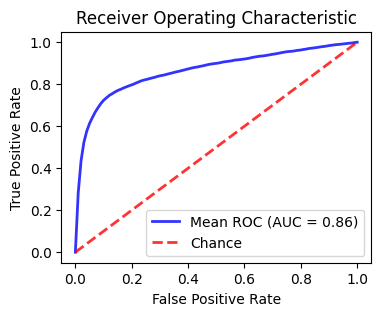

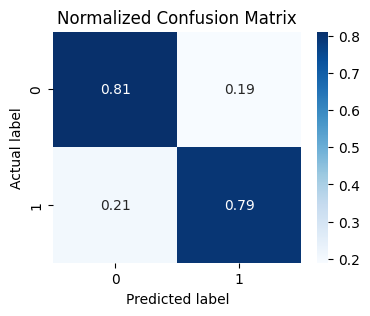

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Metrics for model type: LSTM
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83      8624
         1.0       0.85      0.81      0.83      8624

    accuracy                           0.83     17248
   macro avg       0.83      0.83      0.83     17248
weighted avg       0.83      0.83      0.83     17248

Average Accuracy across 5 folds: 0.8303


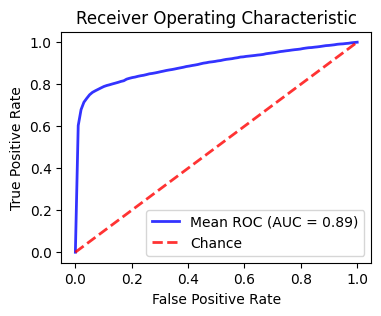

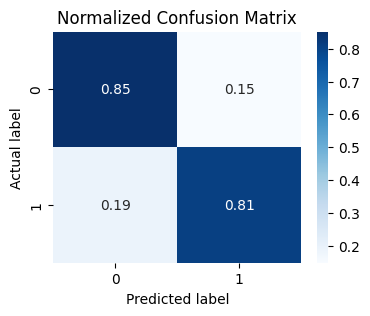

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Metrics for model type: GRU
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82      8624
         1.0       0.83      0.81      0.82      8624

    accuracy                           0.82     17248
   macro avg       0.82      0.82      0.82     17248
weighted avg       0.82      0.82      0.82     17248

Average Accuracy across 5 folds: 0.8208


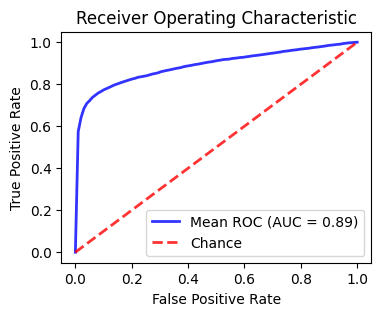

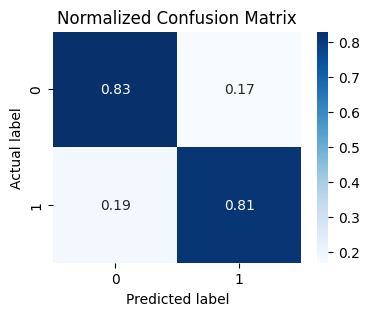

In [22]:
# Compare cross-validation performance of different RNN models
model_types = ['SimpleRNN', 'LSTM', 'GRU']
for model_type in model_types:
    cross_validation(model_type, X_train_resampled, y_train_resampled)